# Load modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import researchpy as rp
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.image import imread
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

from tempfile import NamedTemporaryFile

In [10]:
sns.set_theme('paper')

# Define helper functions

In [2]:
def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

# Load data

In [8]:
gw = pd.read_csv('results_gw.csv')
fgw = pd.read_csv('results_fgw.csv')
glue = pd.read_csv('results_glue.csv')
coot = pd.read_csv('results_coot.csv')

In [11]:
fgw_sub = fgw[fgw.emb_src=='X_pca_norm']

# Overall Comparison of best results

In [12]:
fgw_best = pd.DataFrame({
    'min_foscttm': fgw_sub.groupby('donor')['foscttm'].min(), 
    'max_lta': fgw_sub.groupby('donor')['label_transfer_accuracy'].max(),
    'min_rmse': fgw_sub.groupby('donor')['rmse'].min(),
    'max_nmi': fgw_sub.groupby('donor')['nmi'].max(),
    'max_asw_label': fgw_sub.groupby('donor')['asw_label'].max(),
    'max_ari': fgw_sub.groupby('donor')['ari'].max(),
    'max_asw_batch': fgw_sub.groupby('donor')['asw_batch'].max(),
    'max_graph_connectivity': fgw_sub.groupby('donor')['graph_connectivity'].max(),
})
gw_best = pd.DataFrame({
    'min_foscttm': gw.groupby('donor')['foscttm'].min(), 
    'max_lta': gw.groupby('donor')['label_transfer_accuracy'].max(),
    'min_rmse': gw.groupby('donor')['rmse'].min(),
    'max_nmi': gw.groupby('donor')['nmi'].max(),
    'max_asw_label': gw.groupby('donor')['asw_label'].max(),
    'max_ari': gw.groupby('donor')['ari'].max(),
    'max_asw_batch': gw.groupby('donor')['asw_batch'].max(),
    'max_graph_connectivity': gw.groupby('donor')['graph_connectivity'].max(),
})
glue_best = pd.DataFrame({
    'min_foscttm': glue.groupby('donor')['foscttm'].min(), 
    'max_lta': glue.groupby('donor')['label_transfer_accuracy'].max(),
    'min_rmse': glue.groupby('donor')['rmse'].min(),
    'max_nmi': glue.groupby('donor')['nmi'].max(),
    'max_asw_label': glue.groupby('donor')['asw_label'].max(),
    'max_ari': glue.groupby('donor')['ari'].max(),
    'max_asw_batch': glue.groupby('donor')['asw_batch'].max(),
    'max_graph_connectivity': glue.groupby('donor')['graph_connectivity'].max(),
})

In [15]:
data = pd.concat([
    gw_best.assign(df_name='gw'), 
    fgw_best.assign(df_name='fgw'), 
    glue_best.assign(df_name='glue')]).reset_index()

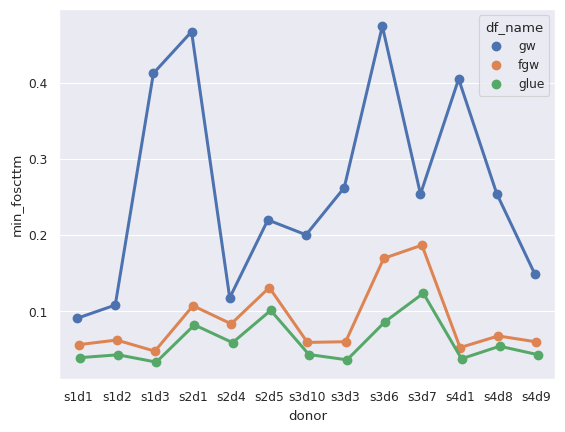

In [16]:
sns.pointplot(data=data, x='donor', y='min_foscttm', hue='df_name', dodge=True)
plt.show()

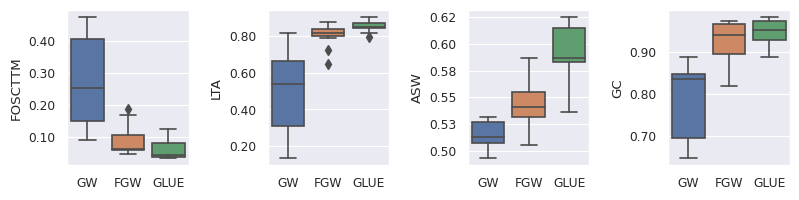

In [18]:
fig, ax = plt.subplots(1,4,figsize=(8,2), gridspec_kw={'wspace':0.65})

sns.boxplot(data = data, y = 'min_foscttm', x = 'df_name', ax = ax[0])
ax[0].set(xlabel=None, ylabel='FOSCTTM', xticklabels=['GW', 'FGW', 'GLUE'])

sns.boxplot(data = data, y = 'max_lta', x = 'df_name', ax = ax[1])
ax[1].set(xlabel=None, ylabel='LTA', xticklabels=['GW', 'FGW', 'GLUE'])

sns.boxplot(data = data, y = 'max_asw_label', x = 'df_name', ax = ax[2])
ax[2].set(xlabel=None, ylabel='ASW', xticklabels=['GW', 'FGW', 'GLUE'])

sns.boxplot(data = data, y = 'max_graph_connectivity', x = 'df_name', ax = ax[3])
ax[3].set(xlabel=None, ylabel='GC', xticklabels=['GW', 'FGW', 'GLUE'])

for axis in ax:
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

set_size(fig, (8, 2))

# plt.savefig('./05_benchmark.png', dpi=300, bbox_inches="tight")

plt.show()

In [19]:
data_mean = pd.DataFrame({
    'FOSCTTM': data.groupby(['df_name'])['min_foscttm'].mean(),
    'LTA': data.groupby(['df_name'])['max_lta'].mean(),
    #'RMSE': data.groupby(['df_name'])['min_rmse'].mean(),
    'ASW': data.groupby(['df_name'])['max_asw_label'].mean(),
    'GC': data.groupby(['df_name'])['max_graph_connectivity'].mean(),
})
data_mean

,FOSCTTM,LTA,ASW,GC
df_name,,,,
fgw,0.087338,0.804178,0.542671,0.924676
glue,0.059515,0.849682,0.587768,0.948082
gw,0.262246,0.492563,0.514085,0.788255


In [20]:
stats.f_oneway(data['min_foscttm'][data['df_name'] == 'gw'],
               data['min_foscttm'][data['df_name'] == 'fgw'],
              data['min_foscttm'][data['df_name'] == 'scglue'])

/dss/dsshome1/01/di93bur/miniconda3/envs/moscot_env_2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


F_onewayResult(statistic=nan, pvalue=nan)

In [21]:
stats.f_oneway(data['min_foscttm'][data['df_name'] == 'fgw'],
              data['min_foscttm'][data['df_name'] == 'scglue'])

F_onewayResult(statistic=nan, pvalue=nan)

In [22]:
data[data.donor == 's1d1'][['df_name', 'min_foscttm', 'max_lta',
                            'min_rmse','max_asw_label','max_graph_connectivity', 
                            'max_nmi', 'max_ari','max_asw_batch']].set_index(['df_name'])

,min_foscttm,max_lta,min_rmse,max_asw_label,max_graph_connectivity,max_nmi,max_ari,max_asw_batch
df_name,,,,,,,,
gw,0.0902,0.661150,0.204395,0.527867,0.760072,0.615508,0.447734,0.696684
fgw,0.0555,0.840617,0.190201,0.555095,0.938757,0.730632,0.679845,0.969106
glue,0.0385,0.846883,0.155038,0.587079,0.949882,0.784018,0.703616,0.928007


In [27]:
'''
for i in ['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3','s3d6', 's3d7', 's4d1', 's4d8', 's4d9']:
    print(i)
    print(data[data.donor == i][['df_name', 'min_foscttm', 'max_lta','min_rmse','max_asw_label','max_graph_connectivity', 'max_nmi', 'max_ari','max_asw_batch']].set_index(['df_name']).round(2).to_latex())
'''    

"\nfor i in ['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3','s3d6', 's3d7', 's4d1', 's4d8', 's4d9']:\n    print(i)\n    print(data[data.donor == i][['df_name', 'min_foscttm', 'max_lta','min_rmse','max_asw_label','max_graph_connectivity', 'max_nmi', 'max_ari','max_asw_batch']].set_index(['df_name']).round(2).to_latex())\n"

# FGW

In [30]:
fgw.head()

,donor,epsilon,alpha,emb_src,emb_tgt,geo_cost_linear,geo_cost_quad,converged,foscttm,label_transfer_accuracy,alignment_score,rmse,nmi,asw_label,ari,asw_batch,graph_connectivity,combined_cost
0,s1d1,0.001,0.25,X_pca_norm,X_lsi_norm,True,True,False,0.0931,0.801896,0.848967,0.203198,0.716976,0.540353,0.670911,0.693436,0.935756,True_True
1,s1d1,0.001,0.25,X_pca_norm,X_lsi_norm,True,False,False,0.1044,0.799004,0.853898,0.210610,0.723066,0.533419,0.679845,0.779884,0.927035,True_False
2,s1d1,0.001,0.25,X_pca_norm,X_lsi_norm,False,True,False,0.1935,0.701639,0.980278,0.259683,0.614088,0.511821,0.469002,0.969106,0.754745,False_True
3,s1d1,0.001,0.25,X_pca_norm,X_lsi_norm,False,False,False,0.1978,0.697783,0.976923,0.259900,0.624771,0.511503,0.544702,0.965137,0.795348,False_False
4,s1d1,0.001,0.25,X_scVI_norm,X_poissonVI_norm,True,True,False,0.0797,0.749679,0.694805,0.219462,0.689148,0.525450,0.579062,0.718347,0.923810,True_True


## Effect of alpha paramter/ adding the fused term

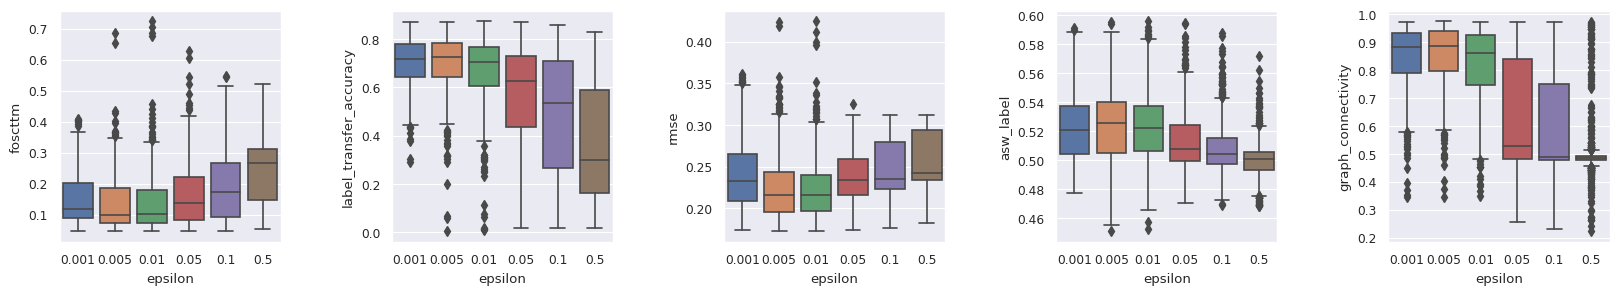

In [32]:
fig, ax = plt.subplots(1,5, figsize=(20,3), gridspec_kw={'wspace':0.5})
sns.boxplot(data = fgw, y = 'foscttm', x = 'epsilon', ax = ax[0])
sns.boxplot(data = fgw, y = 'label_transfer_accuracy', x = 'epsilon', ax = ax[1])
sns.boxplot(data = fgw, y = 'rmse', x = 'epsilon', ax = ax[2])
sns.boxplot(data = fgw, y = 'asw_label', x = 'epsilon', ax = ax[3])
sns.boxplot(data = fgw, y = 'graph_connectivity', x = 'epsilon', ax = ax[4])
plt.show()

In [33]:
fgw_epsilon = fgw[fgw.epsilon==0.005]

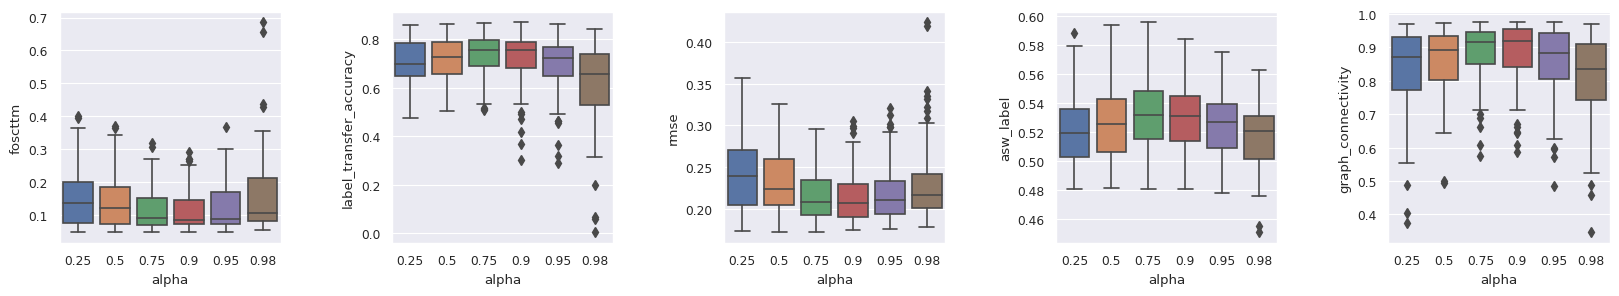

In [35]:
fig, ax = plt.subplots(1,5, figsize=(20,3), gridspec_kw={'wspace':0.5})
sns.boxplot(data = fgw_epsilon, y = 'foscttm', x = 'alpha', ax = ax[0])
sns.boxplot(data = fgw_epsilon, y = 'label_transfer_accuracy', x = 'alpha', ax = ax[1])
sns.boxplot(data = fgw_epsilon, y = 'rmse', x = 'alpha', ax = ax[2])
sns.boxplot(data = fgw_epsilon, y = 'asw_label', x = 'alpha', ax = ax[3])
sns.boxplot(data = fgw_epsilon, y = 'graph_connectivity', x = 'alpha', ax = ax[4])
plt.show()

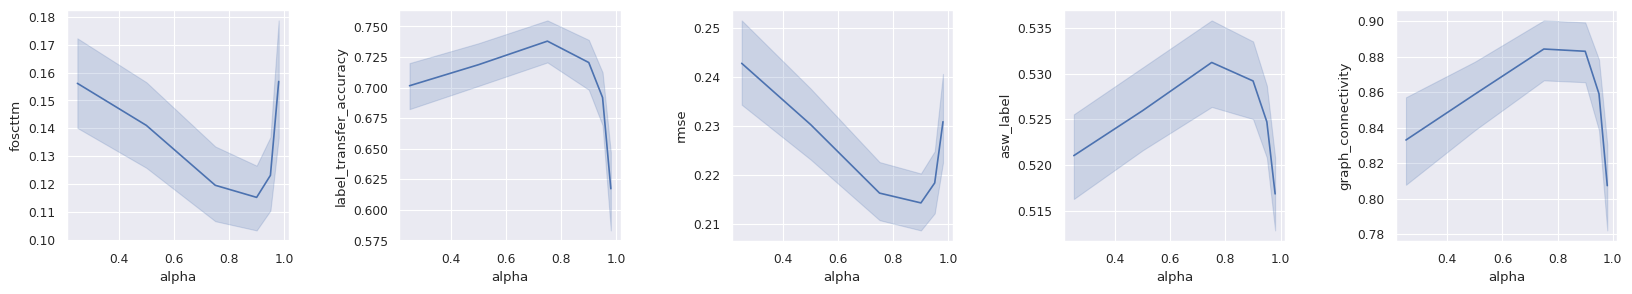

In [36]:
fig, ax = plt.subplots(1,5, figsize=(20,3), gridspec_kw={'wspace':0.5})
sns.lineplot(data = fgw_epsilon, y = 'foscttm', x = 'alpha', ax = ax[0])
sns.lineplot(data = fgw_epsilon, y = 'label_transfer_accuracy', x = 'alpha', ax = ax[1])
sns.lineplot(data = fgw_epsilon, y = 'rmse', x = 'alpha', ax = ax[2])
sns.lineplot(data = fgw_epsilon, y = 'asw_label', x = 'alpha', ax = ax[3])
sns.lineplot(data = fgw_epsilon, y = 'graph_connectivity', x = 'alpha', ax = ax[4])
plt.show()

# Custom cost matrix

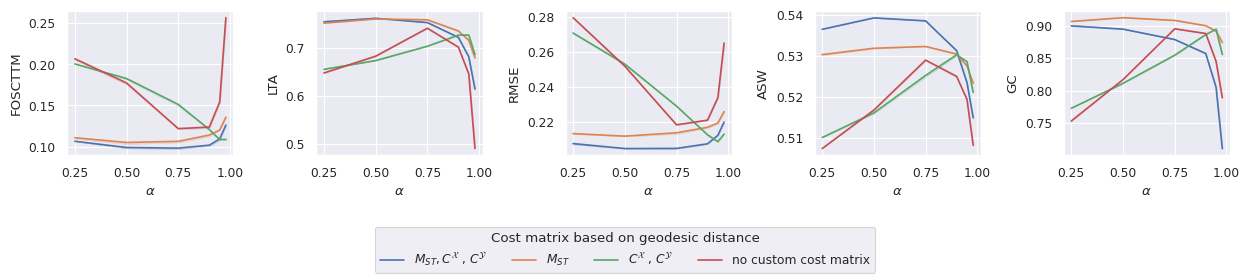

In [37]:
fig, ax = plt.subplots(1,5, figsize=(15,3), gridspec_kw={'wspace':0.5})
sns.lineplot(data = fgw_epsilon, x = 'alpha', hue = 'combined_cost', errorbar=('ci', False), y = 'foscttm', ax = ax[0])
ax[0].legend().remove()
ax[0].set(xlabel=r'$\alpha$', ylabel='FOSCTTM')
sns.lineplot(data = fgw_epsilon, x = 'alpha', hue = 'combined_cost', errorbar=('ci', False), y = 'label_transfer_accuracy', ax = ax[1])
ax[1].legend().remove()
ax[1].set(xlabel=r'$\alpha$', ylabel='LTA')
sns.lineplot(data = fgw_epsilon, x = 'alpha', hue = 'combined_cost', errorbar=('ci', False), y = 'rmse', ax = ax[2])
ax[2].legend().remove()
ax[2].set(xlabel=r'$\alpha$', ylabel='RMSE')
sns.lineplot(data = fgw_epsilon, x = 'alpha', hue = 'combined_cost', errorbar=('ci', False), y = 'asw_label', ax = ax[3])
ax[3].legend().remove()
ax[3].set(xlabel=r'$\alpha$', ylabel='ASW')
sns.lineplot(data = fgw_epsilon, x = 'alpha', hue = 'combined_cost', errorbar=('ci', False), y = 'graph_connectivity', ax = ax[4])
ax[4].legend().remove()
ax[4].set(xlabel=r'$\alpha$', ylabel='GC')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, [r'$M_{ST}, C^{\mathcal{X}}$ , $C^{\mathcal{Y}}$', r'$M_{ST}$', r'$C^{\mathcal{X}}$ , $C^{\mathcal{Y}}$', 'no custom cost matrix'], title="Cost matrix based on geodesic distance", loc='lower center', ncol=4)
fig.subplots_adjust(bottom=0.4, wspace=0.5)
#plt.savefig('./05_geodesic.png')
plt.show()

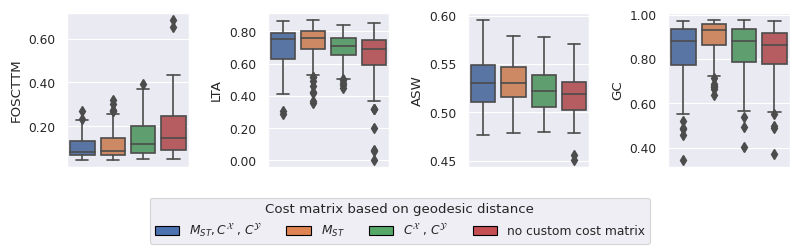

In [38]:
fig, ax = plt.subplots(1,4, gridspec_kw={'wspace':0.65})

sns.boxplot(data = fgw_epsilon, y = 'foscttm',  x = 'combined_cost', ax = ax[0])
ax[0].set(xlabel=None, ylabel='FOSCTTM', xticklabels=[])

sns.boxplot(data = fgw_epsilon, y = 'label_transfer_accuracy', x = 'combined_cost', ax = ax[1])
ax[1].set(xlabel=None, ylabel='LTA', xticklabels=[])

sns.boxplot(data = fgw_epsilon, y = 'asw_label', x = 'combined_cost', ax = ax[2])
ax[2].set(xlabel=None, ylabel='ASW', xticklabels=[])

sns.boxplot(data = fgw_epsilon, y = 'graph_connectivity', x = 'combined_cost', ax = ax[3])
ax[3].set(xlabel=None, ylabel='GC', xticklabels=[])

for axis in ax:
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
# create custom legend
legend_elements = [mpatches.Patch(facecolor='#4c72b0', edgecolor='black', label='A'),
                   mpatches.Patch(facecolor='#dd8452', edgecolor='black', label='B'),
                   mpatches.Patch(facecolor='#55a868', edgecolor='black', label='C'),
                   mpatches.Patch(facecolor='#c44e52', edgecolor='black', label='D')]

fig.legend(legend_elements, [r'$M_{ST}, C^{\mathcal{X}}$ , $C^{\mathcal{Y}}$', r'$M_{ST}$', r'$C^{\mathcal{X}}$ , $C^{\mathcal{Y}}$', 'no custom cost matrix'], title="Cost matrix based on geodesic distance", loc='lower center', ncol=4)

fig.subplots_adjust(bottom=0.3)

set_size(fig, (8, 2.5))

#plt.savefig('./05_geodesic.png', dpi=300, bbox_inches="tight")
plt.show()

In [39]:
fgw_epsilon_best = pd.DataFrame({
    'min_foscttm': fgw_epsilon.groupby(['donor', 'combined_cost'])['foscttm'].min(), 
    'max_lta': fgw_epsilon.groupby(['donor', 'combined_cost'])['label_transfer_accuracy'].max(),
    'max_asw_label': fgw_epsilon.groupby(['donor', 'combined_cost'])['asw_label'].max(),
    'max_graph_connectivity': fgw_epsilon.groupby(['donor', 'combined_cost'])['graph_connectivity'].max(),
})

In [40]:
fgw_epsilon_median = pd.DataFrame({
    'FOSCTTM': fgw_epsilon.groupby(['combined_cost'])['foscttm'].median(),
    'LTA': fgw_epsilon.groupby(['combined_cost'])['label_transfer_accuracy'].median(),
    'ASW': fgw_epsilon.groupby(['combined_cost'])['asw_label'].median(),
    'GC': fgw_epsilon.groupby(['combined_cost'])['graph_connectivity'].median(),
})
fgw_epsilon_median.round(2)

,FOSCTTM,LTA,ASW,GC
combined_cost,,,,
False_False,0.14,0.69,0.52,0.86
False_True,0.12,0.71,0.52,0.88
True_False,0.08,0.76,0.53,0.93
True_True,0.08,0.75,0.53,0.88


In [41]:
fgw_epsilon_mean = pd.DataFrame({
    'FOSCTTM': fgw_epsilon.groupby(['combined_cost'])['foscttm'].mean(),
    'LTA': fgw_epsilon.groupby(['combined_cost'])['label_transfer_accuracy'].mean(),
    # 'RMSE': fgw_epsilon.groupby(['combined_cost'])['rmse'].median(),
    'ASW': fgw_epsilon.groupby(['combined_cost'])['asw_label'].mean(),
    'GC': fgw_epsilon.groupby(['combined_cost'])['graph_connectivity'].mean(),
})
fgw_epsilon_mean.round(2)

,FOSCTTM,LTA,ASW,GC
combined_cost,,,,
False_False,0.17,0.65,0.52,0.83
False_True,0.15,0.69,0.52,0.85
True_False,0.12,0.73,0.53,0.90
True_True,0.11,0.71,0.53,0.84


# Anova with Python:

In [42]:
fgw_epsilon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 48 to 3552
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   donor                    624 non-null    object 
 1   epsilon                  624 non-null    float64
 2   alpha                    624 non-null    float64
 3   emb_src                  624 non-null    object 
 4   emb_tgt                  624 non-null    object 
 5   geo_cost_linear          624 non-null    bool   
 6   geo_cost_quad            624 non-null    bool   
 7   converged                624 non-null    bool   
 8   foscttm                  624 non-null    float64
 9   label_transfer_accuracy  624 non-null    float64
 10  alignment_score          624 non-null    float64
 11  rmse                     624 non-null    float64
 12  nmi                      624 non-null    float64
 13  asw_label                624 non-null    float64
 14  ari                     

In [43]:
rp.summary_cont(fgw_epsilon['foscttm'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,foscttm,624.0,0.1353,0.0838,0.0034,0.1287,0.1419


In [44]:
rp.summary_cont(fgw_epsilon['foscttm'].groupby(fgw_epsilon['combined_cost']))

,N,Mean,SD,SE,95% Conf.,Interval
combined_cost,,,,,,
False_False,156,0.1734,0.1076,0.0086,0.1564,0.1904
False_True,156,0.1455,0.0809,0.0065,0.1327,0.1583
True_False,156,0.1154,0.0660,0.0053,0.1050,0.1259
True_True,156,0.1069,0.0544,0.0044,0.0983,0.1155


In [45]:
stats.f_oneway(fgw_epsilon['foscttm'][fgw_epsilon['combined_cost'] == 'False_False'],
               fgw_epsilon['foscttm'][fgw_epsilon['combined_cost'] == 'False_True'],
               fgw_epsilon['foscttm'][fgw_epsilon['combined_cost'] == 'True_False'],
               fgw_epsilon['foscttm'][fgw_epsilon['combined_cost'] == 'True_True'])

F_onewayResult(statistic=22.556974697786565, pvalue=7.15898762766209e-14)

Interpretation:
Changing the cost in different positions was tested:
1. Nowhere
2. in quadratic
3. in linear
4. in both terms of the optimization problem

purpose: test if the geodesic cost significantly improves the alignement performance

H0: x_1 = x_2 = x_3 = x_4 (all means are similar)
HA: at least on of the groups means differ
 
One rejects H0, if the computed F-static is greater than the critical F-statistic (depends on degree of freedom and alpha, lookup table)

overall foscttm: 0.135 95% CI(0.129, 0.142) with group averages of 
- 0.173 95% CI(0.156, 0.190) for False_False
- 0.146 95% CI(0.133, 0.158) for False_True 
- 0.115 95% CI(0.105, 0.126) for True_False
- 0.107 95% CI(0.098, 0.116) for True_True. 

F = 22.56, p = 7.16 e-14
Thus: test is statistical sigificant

# Embedding: LSA/PCA vs. scVI/PoissonATAC

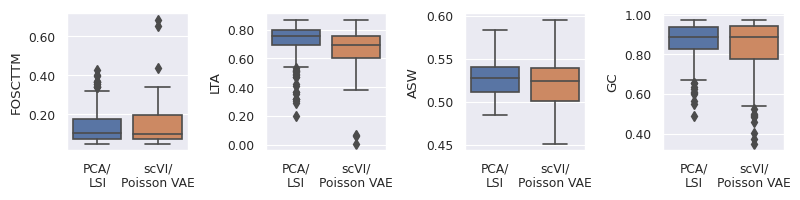

In [46]:
fig, ax = plt.subplots(1,4, gridspec_kw={'wspace':0.65})

sns.boxplot(data = fgw_epsilon, y = 'foscttm',  x = 'emb_src', ax = ax[0])
ax[0].set(xlabel=None, ylabel='FOSCTTM', xticklabels=['PCA/\nLSI', 'scVI/\nPoisson VAE'])

sns.boxplot(data = fgw_epsilon, y = 'label_transfer_accuracy', x = 'emb_src', ax = ax[1])
ax[1].set(xlabel=None, ylabel='LTA', xticklabels=['PCA/\nLSI', 'scVI/\nPoisson VAE'])

sns.boxplot(data = fgw_epsilon, y = 'asw_label', x = 'emb_src', ax = ax[2])
ax[2].set(xlabel=None, ylabel='ASW', xticklabels=['PCA/\nLSI', 'scVI/\nPoisson VAE'])

sns.boxplot(data = fgw_epsilon, y = 'graph_connectivity', x = 'emb_src', ax = ax[3])
ax[3].set(xlabel=None, ylabel='GC', xticklabels=['PCA/\nLSI', 'scVI/\nPoisson VAE'])

for axis in ax:
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

set_size(fig, (8, 2))

# plt.savefig('./05_embedding.png', dpi=300, bbox_inches="tight")
plt.show()

In [47]:
fgw_embedding = pd.DataFrame({
    'min_foscttm': fgw_epsilon.groupby(['donor', 'emb_src'])['foscttm'].min(), 
    'max_lta': fgw_epsilon.groupby(['donor', 'emb_src'])['label_transfer_accuracy'].max(),
    'min_rmse': fgw_epsilon.groupby(['donor', 'emb_src'])['rmse'].min(),
    'max_asw_label': fgw_epsilon.groupby(['donor', 'emb_src'])['asw_label'].max(),
    'max_graph_connectivity': fgw_epsilon.groupby(['donor', 'emb_src'])['graph_connectivity'].max(),
})

In [48]:
fgw_embedding_median = pd.DataFrame({
    'FOSCTTM': fgw_epsilon.groupby(['emb_src'])['foscttm'].median(),
    'LTA': fgw_epsilon.groupby(['emb_src'])['label_transfer_accuracy'].median(),
    #'RMSE': fgw_epsilon.groupby(['emb_src'])['rmse'].median(),
    'ASW': fgw_epsilon.groupby(['emb_src'])['asw_label'].median(),
    'GC': fgw_epsilon.groupby(['emb_src'])['graph_connectivity'].median(),
})
fgw_embedding_median.round(2)

,FOSCTTM,LTA,ASW,GC
emb_src,,,,
X_pca_norm,0.1,0.76,0.53,0.89
X_scVI_norm,0.1,0.69,0.52,0.89


In [49]:
rp.summary_cont(fgw_epsilon['foscttm'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,foscttm,624.0,0.1353,0.0838,0.0034,0.1287,0.1419


In [50]:
rp.summary_cont(fgw_epsilon['foscttm'].groupby(fgw_epsilon['emb_src']))

,N,Mean,SD,SE,95% Conf.,Interval
emb_src,,,,,,
X_pca_norm,312,0.1347,0.0831,0.0047,0.1255,0.1440
X_scVI_norm,312,0.1359,0.0846,0.0048,0.1264,0.1453


In [51]:
stats.f_oneway(fgw_epsilon['foscttm'][fgw_epsilon['emb_src'] == 'X_pca_norm'],
               fgw_epsilon['foscttm'][fgw_epsilon['emb_src'] == 'X_scVI_norm'])

F_onewayResult(statistic=0.02879116899017316, pvalue=0.8653172831490477)

In [52]:
stats.ttest_ind(fgw_epsilon['foscttm'][fgw_epsilon['emb_src'] == 'X_pca_norm'],
               fgw_epsilon['foscttm'][fgw_epsilon['emb_src'] == 'X_scVI_norm'])

Ttest_indResult(statistic=-0.16967960687770853, pvalue=0.8653172831491571)

In [53]:
stats.ttest_ind(fgw_epsilon['label_transfer_accuracy'][fgw_epsilon['emb_src'] == 'X_pca_norm'],
               fgw_epsilon['label_transfer_accuracy'][fgw_epsilon['emb_src'] == 'X_scVI_norm'])

Ttest_indResult(statistic=5.937959346300385, pvalue=4.800192779899081e-09)

In [54]:
stats.ttest_ind(fgw_epsilon['asw_label'][fgw_epsilon['emb_src'] == 'X_pca_norm'],
               fgw_epsilon['asw_label'][fgw_epsilon['emb_src'] == 'X_scVI_norm'])

Ttest_indResult(statistic=2.1097100001067863, pvalue=0.035282199562736316)

In [55]:
stats.ttest_ind(fgw_epsilon['graph_connectivity'][fgw_epsilon['emb_src'] == 'X_pca_norm'],
               fgw_epsilon['graph_connectivity'][fgw_epsilon['emb_src'] == 'X_scVI_norm'])

Ttest_indResult(statistic=3.0089526489678318, pvalue=0.0027275333131045127)

# COOT

In [56]:
coot_best = pd.DataFrame({
    'min_foscttm': coot.groupby('donor')['foscttm'].min(), 
    'max_lta': coot.groupby('donor')['label_transfer_accuracy'].max(),
    'min_rmse': coot.groupby('donor')['rmse'].min(),
    'max_asw_label': coot.groupby('donor')['asw_label'].max(),
    'max_graph_connectivity': coot.groupby('donor')['graph_connectivity'].max(),
    'max_nmi': coot.groupby('donor')['nmi'].max(),
    'max_ari': coot.groupby('donor')['ari'].max(),
    'max_asw_batch': coot.groupby('donor')['asw_batch'].max(),
})

In [57]:
print(coot_best.round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  min\_foscttm &  max\_lta &  min\_rmse &  max\_asw\_label &  max\_graph\_connectivity &  max\_nmi &  max\_ari &  max\_asw\_batch \\
donor &              &          &           &                &                         &          &          &                \\
\midrule
s1d1  &         0.32 &     0.33 &      0.23 &           0.51 &                    0.75 &     0.61 &     0.41 &           0.79 \\
s1d2  &         0.35 &     0.34 &      0.23 &           0.51 &                    0.69 &     0.51 &     0.31 &           0.74 \\
s1d3  &         0.47 &     0.12 &      0.23 &           0.50 &                    0.65 &     0.61 &     0.37 &           0.74 \\
s2d1  &         0.42 &     0.34 &      0.24 &           0.51 &                    0.77 &     0.53 &     0.35 &           0.81 \\
s2d4  &         0.51 &     0.14 &      0.24 &           0.50 &                    0.77 &     0.57 &     0.37 &           0.81 \\
s2d5  &         0.50 &     0.35 &      0.24 

/tmp/ipykernel_4083081/3362805408.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(coot_best.round(2).to_latex())


In [60]:
data_all = pd.concat([
    coot_best.assign(df_name='COOT'),
    gw_best.assign(df_name='GW'), 
    fgw_best.assign(df_name='FGW'), 
    #glue_best.assign(df_name='GLUE')
]).reset_index()

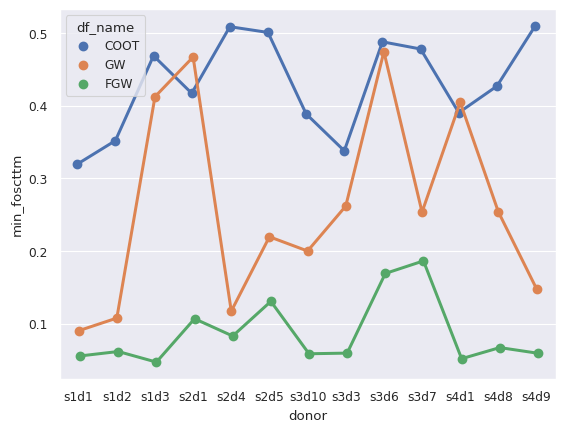

In [61]:
sns.pointplot(data=data_all, x='donor', y='min_foscttm', hue='df_name', dodge=True)
plt.show()

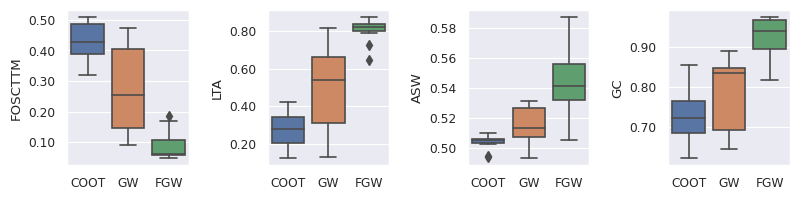

In [62]:
fig, ax = plt.subplots(1,4, gridspec_kw={'wspace':0.65})

sns.boxplot(data = data_all, y = 'min_foscttm',  x = 'df_name', ax = ax[0])
ax[0].set(xlabel=None, ylabel='FOSCTTM')

sns.boxplot(data = data_all, y = 'max_lta', x = 'df_name', ax = ax[1])
ax[1].set(xlabel=None, ylabel='LTA')

sns.boxplot(data = data_all, y = 'max_asw_label', x = 'df_name', ax = ax[2])
ax[2].set(xlabel=None, ylabel='ASW')

sns.boxplot(data = data_all, y = 'max_graph_connectivity', x = 'df_name', ax = ax[3])
ax[3].set(xlabel=None, ylabel='GC')

for axis in ax:
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

set_size(fig, (8, 2))

# plt.savefig('./05_coot.png', dpi=300, bbox_inches="tight")
plt.show()